# 03 — State Vector Analysis (48 Feature)

> **Girdi:** `data/processed/state.parquet`  
> **Amaç:** 48-feature state vektörünün kapsamlı analizi — dağılımlar, null oranları, korelasyonlar ve klinik skorlar.

---

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Stil ayarları
plt.rcParams.update({
    'figure.figsize': (14, 6),
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'figure.dpi': 100,
    'axes.grid': True,
    'grid.alpha': 0.3,
})
sns.set_style('whitegrid')
palette = sns.color_palette('viridis', 10)

print('✅ Kütüphaneler yüklendi.')

✅ Kütüphaneler yüklendi.


## 1. Veri Yükleme & Genel Bakış

In [2]:
df = pl.read_parquet('../data/processed/state.parquet')

print(f'Shape: {df.shape[0]:,} satır × {df.shape[1]} sütun')
print(f'Unique stay_id: {df["stay_id"].n_unique():,}')
print(f'\nBellek kullanımı: {df.estimated_size("mb"):.1f} MB')
print(f'\nZaman aralığı: {df["hour_bin"].min()} → {df["hour_bin"].max()}')
print(f'\nSütunlar ({df.shape[1]}):')
for i, (col, dtype) in enumerate(zip(df.columns, df.dtypes), 1):
    print(f'  {i:2d}. {col:30s} {str(dtype):15s}')

Shape: 8,808,129 satır × 50 sütun
Unique stay_id: 94,458

Bellek kullanımı: 3360.0 MB

Zaman aralığı: 2110-01-11 10:00:00 → 2214-08-11 05:00:00

Sütunlar (50):
   1. stay_id                        Int64          
   2. hour_bin                       Datetime(time_unit='us', time_zone=None)
   3. age                            Float64        
   4. gender                         Float64        
   5. weight_kg                      Float64        
   6. elixhauser_score               Float64        
   7. icu_readmission                Float64        
   8. sofa_score                     Float64        
   9. sirs_score                     Float64        
  10. gcs_total                      Float64        
  11. heart_rate                     Float64        
  12. sbp                            Float64        
  13. dbp                            Float64        
  14. mbp                            Float64        
  15. shock_index                    Float64        
  16. spo2          

In [3]:
# Meta sütunları ayır
meta_cols = ['stay_id', 'hour_bin']
feature_cols = [c for c in df.columns if c not in meta_cols]

print(f'Meta sütunlar: {meta_cols}')
print(f'Feature sayısı: {len(feature_cols)}')

# İlk 5 satır
df.head(5)

Meta sütunlar: ['stay_id', 'hour_bin']
Feature sayısı: 48


stay_id,hour_bin,age,gender,weight_kg,elixhauser_score,icu_readmission,sofa_score,sirs_score,gcs_total,heart_rate,sbp,dbp,mbp,shock_index,spo2,temp_c,resp_rate,potassium,sodium,chloride,glucose,creatinine,magnesium,calcium_total,ionized_calcium,sgot,sgpt,bilirubin_total,albumin,hemoglobin,wbc,platelet,ptt,pt,inr,bun,ph,pao2,paco2,base_excess,bicarbonate,co2_total,lactate,hco3,pf_ratio,mechanical_ventilation,fio2,urine_output,cumulative_fluid_balance
i64,datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
30000153,2174-09-29 12:00:00,61.0,0.0,73.0,1.0,0.0,3.0,1.0,9.0,100.0,136.0,74.0,89.0,0.735294,100.0,37.1,18.0,4.0,139.0,103.0,125.0,1.0,2.1,8.4,1.13,37.0,28.0,0.6,2.9,9.4,10.6,196.0,31.4,13.8,1.2,23.0,7.4,92.0,41.0,0.0,24.0,26.0,1.4,24.0,217.142857,1.0,75.0,280.0,-250.0
30000153,2174-09-29 13:00:00,61.0,0.0,73.0,1.0,0.0,4.0,1.0,9.0,104.0,132.0,74.5,84.0,0.787879,100.0,37.1,16.0,4.0,139.0,103.0,125.0,1.0,2.1,8.4,1.16,37.0,28.0,0.6,2.9,9.4,10.6,196.0,31.4,13.8,1.2,23.0,7.3,221.0,45.0,-3.0,24.0,23.0,1.3,24.0,294.666667,1.0,75.0,280.0,-500.0
30000153,2174-09-29 14:00:00,61.0,0.0,73.0,1.0,0.0,4.0,0.0,9.0,83.0,131.0,61.0,80.0,0.633588,100.0,37.1,16.0,4.0,139.0,103.0,125.0,1.0,2.1,8.4,1.1,37.0,28.0,0.6,2.9,9.4,10.6,196.0,31.4,13.8,1.2,23.0,7.3,263.0,45.0,-3.0,24.0,23.0,2.1,24.0,350.666667,1.0,75.0,45.0,-515.0
30000153,2174-09-29 15:00:00,61.0,0.0,73.0,1.0,0.0,3.0,2.0,9.0,92.0,123.0,65.0,84.0,0.747967,100.0,37.1,14.0,4.4,142.0,115.0,192.0,0.9,1.5,7.4,1.1,37.0,28.0,0.6,2.9,10.8,17.0,173.0,25.3,13.2,1.1,22.0,7.3,263.0,45.0,-3.0,19.0,23.0,2.1,19.0,526.0,1.0,50.0,50.0,-535.0
30000153,2174-09-29 16:00:00,61.0,0.0,73.0,1.0,0.0,2.0,1.0,11.0,83.0,109.0,55.0,71.0,0.761468,100.0,37.1,16.0,4.4,142.0,115.0,192.0,0.9,1.5,7.4,1.1,37.0,28.0,0.6,2.9,10.8,17.0,173.0,25.3,13.2,1.1,22.0,7.31,215.0,42.0,-4.0,19.0,22.0,2.1,19.0,430.0,1.0,50.0,50.0,356.299999


## 2. Temel İstatistikler

In [4]:
# Describe — tüm feature'lar için
desc = df.select(feature_cols).describe()
print('📊 Temel İstatistikler:')
desc

📊 Temel İstatistikler:


statistic,age,gender,weight_kg,elixhauser_score,icu_readmission,sofa_score,sirs_score,gcs_total,heart_rate,sbp,dbp,mbp,shock_index,spo2,temp_c,resp_rate,potassium,sodium,chloride,glucose,creatinine,magnesium,calcium_total,ionized_calcium,sgot,sgpt,bilirubin_total,albumin,hemoglobin,wbc,platelet,ptt,pt,inr,bun,ph,pao2,paco2,base_excess,bicarbonate,co2_total,lactate,hco3,pf_ratio,mechanical_ventilation,fio2,urine_output,cumulative_fluid_balance
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6,8.808129e6
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",62.641503,0.423862,84.016129,5.388534,0.132441,4.717584,1.235449,11.948438,87.80774,120.459059,65.159634,84.463214,0.74698,137.565982,37.308589,21.159613,4.097563,139.018948,103.069681,136.951262,1.455567,2.114966,8.464606,1.133782,96.446785,72.765459,1.60946,2.895569,9.755728,12.036486,218.313802,37.593546,15.420518,1.406221,30.508985,7.397653,98.576267,42.020572,0.611444,24.723072,26.455694,2.741112,24.723072,249.596147,0.663667,44.327502,180.953608,3403.062962
"""std""",16.111648,0.494169,24.935848,2.543507,0.33897,3.679663,0.974798,3.815196,3789.1821,489.333936,258.149001,4810.543799,13.927985,19358.737762,4.028527,2401.039451,0.549071,5.193031,6.478984,55.33864,1.431951,0.376734,0.741901,0.278067,512.634218,325.585556,4.199208,0.443703,1.912019,8.216725,128.652579,18.855,6.418318,0.620163,24.572125,0.061808,50.589626,9.082426,4.953357,4.92296,5.189113,1216.153386,4.92296,331.415231,0.472454,40.612518,353.773672,98555.968666
"""min""",18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-241395.0,-94.0,-40.0,-9806.0,-3094.807692,-951234.0,0.0,0.0,0.8,67.0,39.0,0.0,0.0,0.0,0.0,0.099,0.0,0.0,0.0,0.2,0.0,0.0,5.0,11.9,7.1,0.5,0.0,0.94,-32.0,0.0,-414.0,2.0,-11.0,0.0,2.0,0.0,0.0,0.0,-3765.0,-1.0222e6
"""25%""",53.0,0.0,67.4,4.0,0.0,2.0,0.0,10.0,73.0,104.0,53.666667,69.0,0.590164,95.0,37.1,16.0,3.8,136.0,99.0,106.0,0.7,1.9,8.0,1.12,31.0,22.0,0.5,2.9,8.3,7.9,135.0,28.1,12.6,1.1,15.0,7.37,75.0,37.0,-1.0,22.0,24.0,1.2,22.0,186.0,0.0,40.0,50.0,-4225.0
"""50%""",64.0,0.0,80.2,5.0,0.0,4.0,1.0,14.0,85.0,118.0,62.0,78.0,0.712121,97.0,37.1,19.25,4.0,139.0,103.0,125.0,1.0,2.1,8.4,1.13,37.0,28.0,0.6,2.9,9.4,10.6,196.0,31.4,13.8,1.2,23.0,7.4,92.0,41.0,0.0,24.0,26.0,1.4,24.0,217.142857,1.0,40.0,120.0,1092.235294
"""75%""",75.0,1.0,96.497162,7.0,0.0,7.0,2.0,15.0,97.0,134.0,73.0,89.0,0.858491,99.0,37.1,24.0,4.4,142.0,107.0,152.0,1.6,2.3,8.9,1.14,46.0,35.0,0.8,2.9,10.9,14.2,273.0,37.7,15.5,1.4,38.0,7.43,112.0,44.0,2.0,27.0,28.0,1.6,27.0,250.0,1.0,50.0,250.0,12319.799722
"""max""",91.0,1.0,1007.881424,16.0,1.0,23.0,4.0,15.0,1e7,1.00311e6,114109.0,8.99909e6,40906.24,9.9e6,987.4,7.0004e6,26.5,185.0,155.0,5840.0,80.0,86.0,59.0,150.0,42606.0,61854.0,87.2,6.8,24.6,572.5,2385.0,154.9,150.0,27.4,305.0,7.96,4242.0,243.0,57.0,50.0,104.0,1.276103e6,50.0,26050.0,1.0,40100.0,876587.0,1.7041e7


## 3. Null (Eksik Veri) Analizi

✅ Hiçbir feature null içermiyor — imputation başarılı!


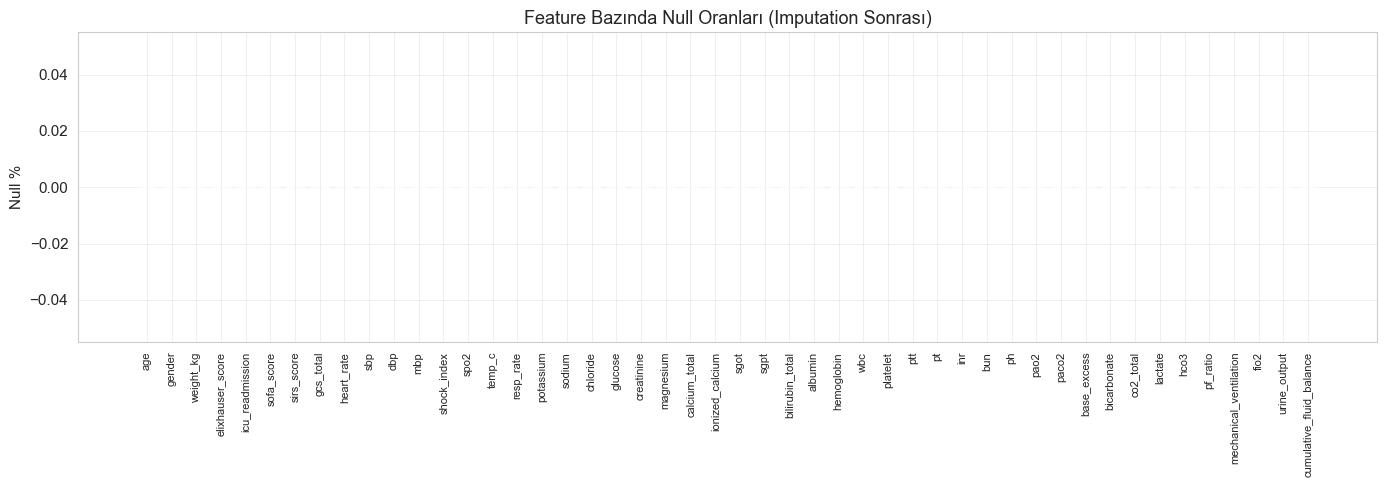

In [5]:
# Null sayıları ve yüzdeleri
null_counts = {col: df[col].null_count() for col in feature_cols}
null_pcts = {col: count / df.shape[0] * 100 for col, count in null_counts.items()}

# Sadece null > 0 olanları göster
null_df = (
    pl.DataFrame({
        'feature': list(null_pcts.keys()),
        'null_count': list(null_counts.values()),
        'null_pct': list(null_pcts.values()),
    })
    .sort('null_pct', descending=True)
)

has_null = null_df.filter(pl.col('null_count') > 0)
if has_null.shape[0] > 0:
    print(f'⚠️  {has_null.shape[0]} feature hâlâ null içeriyor:')
    print(has_null)
else:
    print('✅ Hiçbir feature null içermiyor — imputation başarılı!')

# Bar chart
fig, ax = plt.subplots(figsize=(14, 5))
colors = ['#e74c3c' if p > 10 else '#f39c12' if p > 1 else '#2ecc71' for p in null_pcts.values()]
ax.bar(null_pcts.keys(), null_pcts.values(), color=colors, edgecolor='white', linewidth=0.5)
ax.set_ylabel('Null %')
ax.set_title('Feature Bazında Null Oranları (Imputation Sonrası)')
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

## 4. Demografik Özellikler

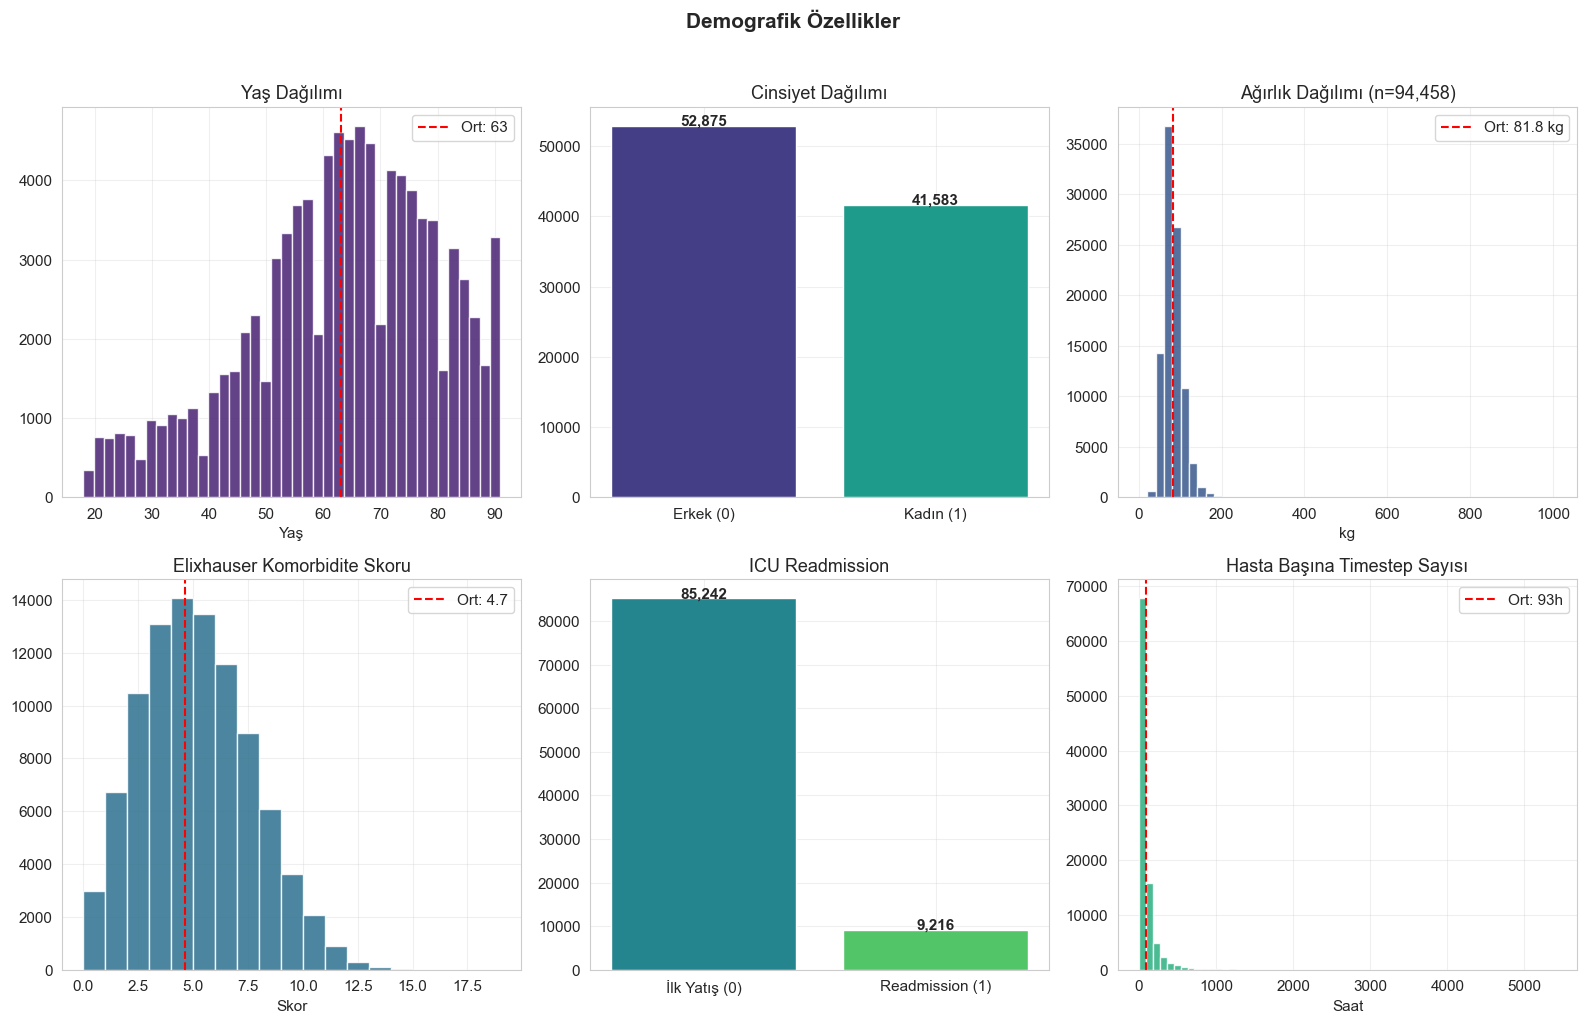


📊 Demografik Özet:
  Yaş → min: 18.0, max: 91.0, ort: 63
  Ağırlık → min: 0.0, max: 1007.881424, ort: 81.8 kg
  Elixhauser → min: 0.0, max: 16.0, ort: 4.7
  ICU Readmission: [9216] / 94,458


In [6]:
# Hasta bazında demografik bilgiler (her stay_id için ilk satır)
demo = df.group_by('stay_id').first().select(['stay_id', 'age', 'gender', 'weight_kg', 'elixhauser_score', 'icu_readmission'])

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Yaş dağılımı
axes[0, 0].hist(demo['age'].to_numpy(), bins=40, color=palette[0], edgecolor='white', alpha=0.85)
axes[0, 0].set_title('Yaş Dağılımı')
axes[0, 0].set_xlabel('Yaş')
axes[0, 0].axvline(demo['age'].mean(), color='red', linestyle='--', label=f'Ort: {demo["age"].mean():.0f}')
axes[0, 0].legend()

# Cinsiyet dağılımı
gender_counts = demo['gender'].value_counts().sort('gender')
labels = ['Erkek (0)', 'Kadın (1)']
axes[0, 1].bar(labels, gender_counts['count'].to_list(), color=[palette[1], palette[5]], edgecolor='white')
axes[0, 1].set_title('Cinsiyet Dağılımı')
for i, v in enumerate(gender_counts['count'].to_list()):
    axes[0, 1].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')

# Ağırlık dağılımı
w = demo.filter(pl.col('weight_kg').is_not_null())['weight_kg'].to_numpy()
axes[0, 2].hist(w, bins=50, color=palette[2], edgecolor='white', alpha=0.85)
axes[0, 2].set_title(f'Ağırlık Dağılımı (n={len(w):,})')
axes[0, 2].set_xlabel('kg')
axes[0, 2].axvline(np.nanmean(w), color='red', linestyle='--', label=f'Ort: {np.nanmean(w):.1f} kg')
axes[0, 2].legend()

# Elixhauser skoru
axes[1, 0].hist(demo['elixhauser_score'].to_numpy(), bins=range(0, 20), color=palette[3], edgecolor='white', alpha=0.85)
axes[1, 0].set_title('Elixhauser Komorbidite Skoru')
axes[1, 0].set_xlabel('Skor')
axes[1, 0].axvline(demo['elixhauser_score'].mean(), color='red', linestyle='--', label=f'Ort: {demo["elixhauser_score"].mean():.1f}')
axes[1, 0].legend()

# ICU Readmission
readmit_counts = demo['icu_readmission'].value_counts().sort('icu_readmission')
axes[1, 1].bar(['İlk Yatış (0)', 'Readmission (1)'], readmit_counts['count'].to_list(), 
               color=[palette[4], palette[7]], edgecolor='white')
axes[1, 1].set_title('ICU Readmission')
for i, v in enumerate(readmit_counts['count'].to_list()):
    axes[1, 1].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')

# Hasta başına timestep sayısı
ts_per_patient = df.group_by('stay_id').len()
axes[1, 2].hist(ts_per_patient['len'].to_numpy(), bins=60, color=palette[6], edgecolor='white', alpha=0.85)
axes[1, 2].set_title('Hasta Başına Timestep Sayısı')
axes[1, 2].set_xlabel('Saat')
axes[1, 2].axvline(ts_per_patient['len'].mean(), color='red', linestyle='--', label=f'Ort: {ts_per_patient["len"].mean():.0f}h')
axes[1, 2].legend()

plt.suptitle('Demografik Özellikler', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f'\n📊 Demografik Özet:')
print(f'  Yaş → min: {demo["age"].min()}, max: {demo["age"].max()}, ort: {demo["age"].mean():.0f}')
print(f'  Ağırlık → min: {demo["weight_kg"].min()}, max: {demo["weight_kg"].max()}, ort: {demo["weight_kg"].mean():.1f} kg')
print(f'  Elixhauser → min: {demo["elixhauser_score"].min()}, max: {demo["elixhauser_score"].max()}, ort: {demo["elixhauser_score"].mean():.1f}')
print(f'  ICU Readmission: {readmit_counts.filter(pl.col("icu_readmission")==1)["count"].to_list()} / {demo.shape[0]:,}')

## 5. Yaşamsal Bulgular (Vitals) Dağılımları

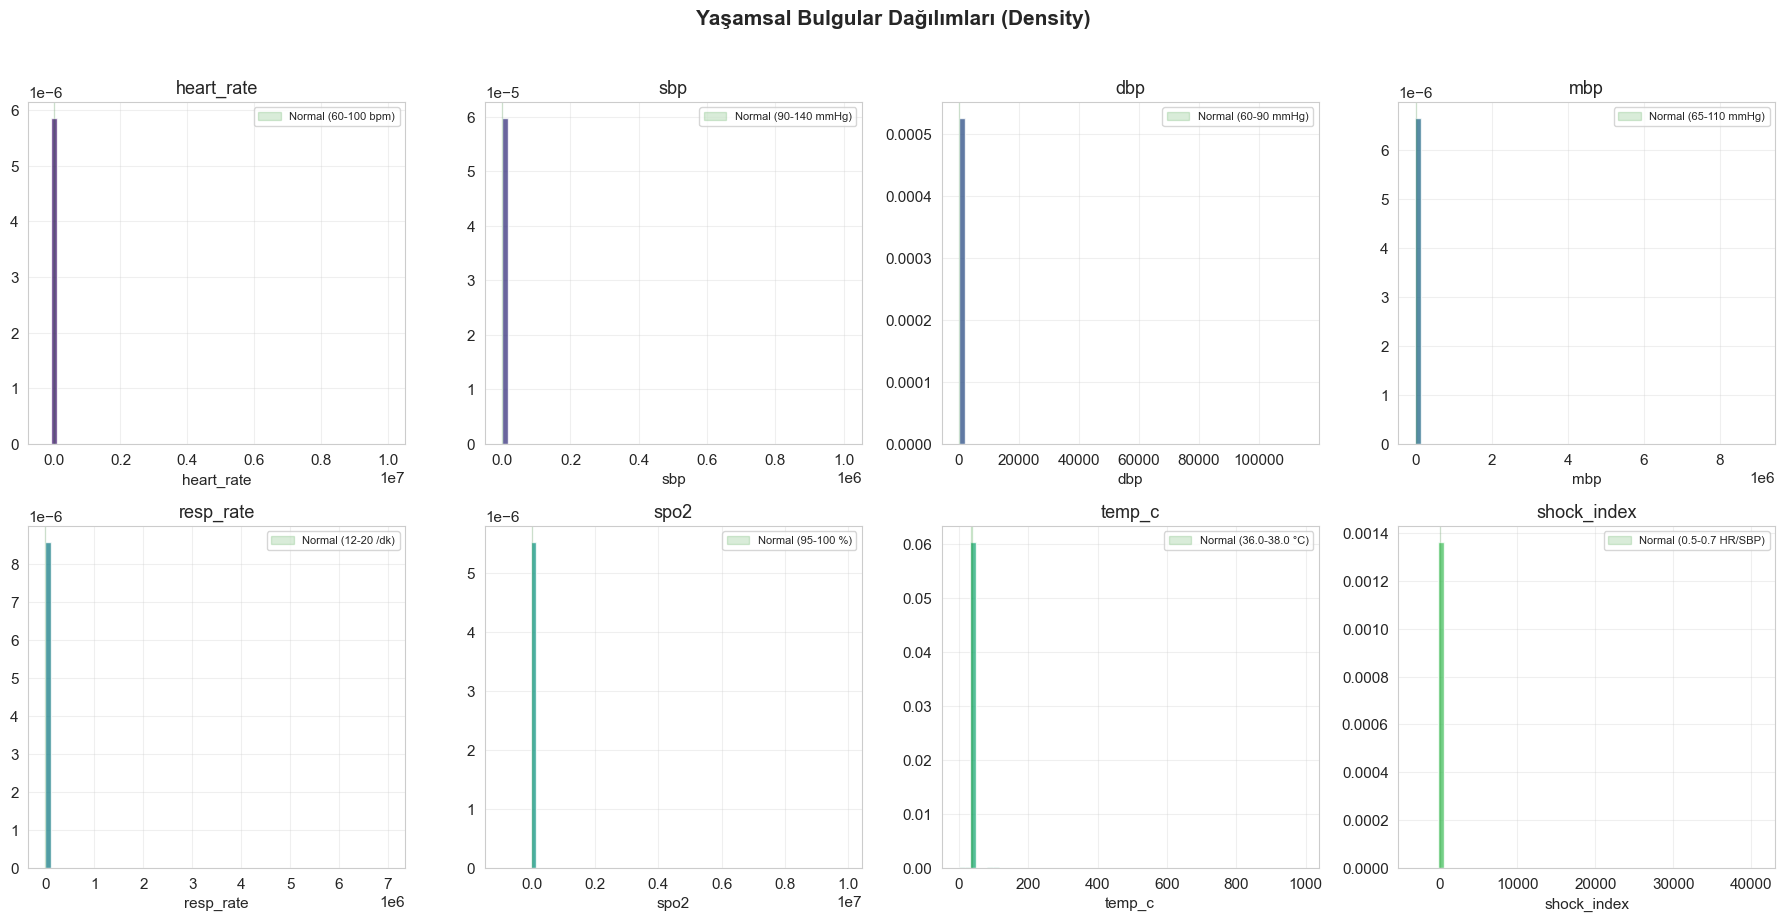

In [7]:
vitals = ['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 'temp_c', 'shock_index']

fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

# Klinik referans aralıkları
ref_ranges = {
    'heart_rate': (60, 100, 'bpm'),
    'sbp': (90, 140, 'mmHg'),
    'dbp': (60, 90, 'mmHg'),
    'mbp': (65, 110, 'mmHg'),
    'resp_rate': (12, 20, '/dk'),
    'spo2': (95, 100, '%'),
    'temp_c': (36.0, 38.0, '°C'),
    'shock_index': (0.5, 0.7, 'HR/SBP'),
}

for i, vital in enumerate(vitals):
    data = df[vital].drop_nulls().to_numpy()
    axes[i].hist(data, bins=60, color=palette[i % len(palette)], edgecolor='white', alpha=0.8, density=True)
    axes[i].set_title(f'{vital}')
    
    if vital in ref_ranges:
        lo, hi, unit = ref_ranges[vital]
        axes[i].axvspan(lo, hi, alpha=0.15, color='green', label=f'Normal ({lo}-{hi} {unit})')
        axes[i].legend(fontsize=8)
    
    axes[i].set_xlabel(vital)

plt.suptitle('Yaşamsal Bulgular Dağılımları (Density)', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. Laboratuvar Değerleri Dağılımları

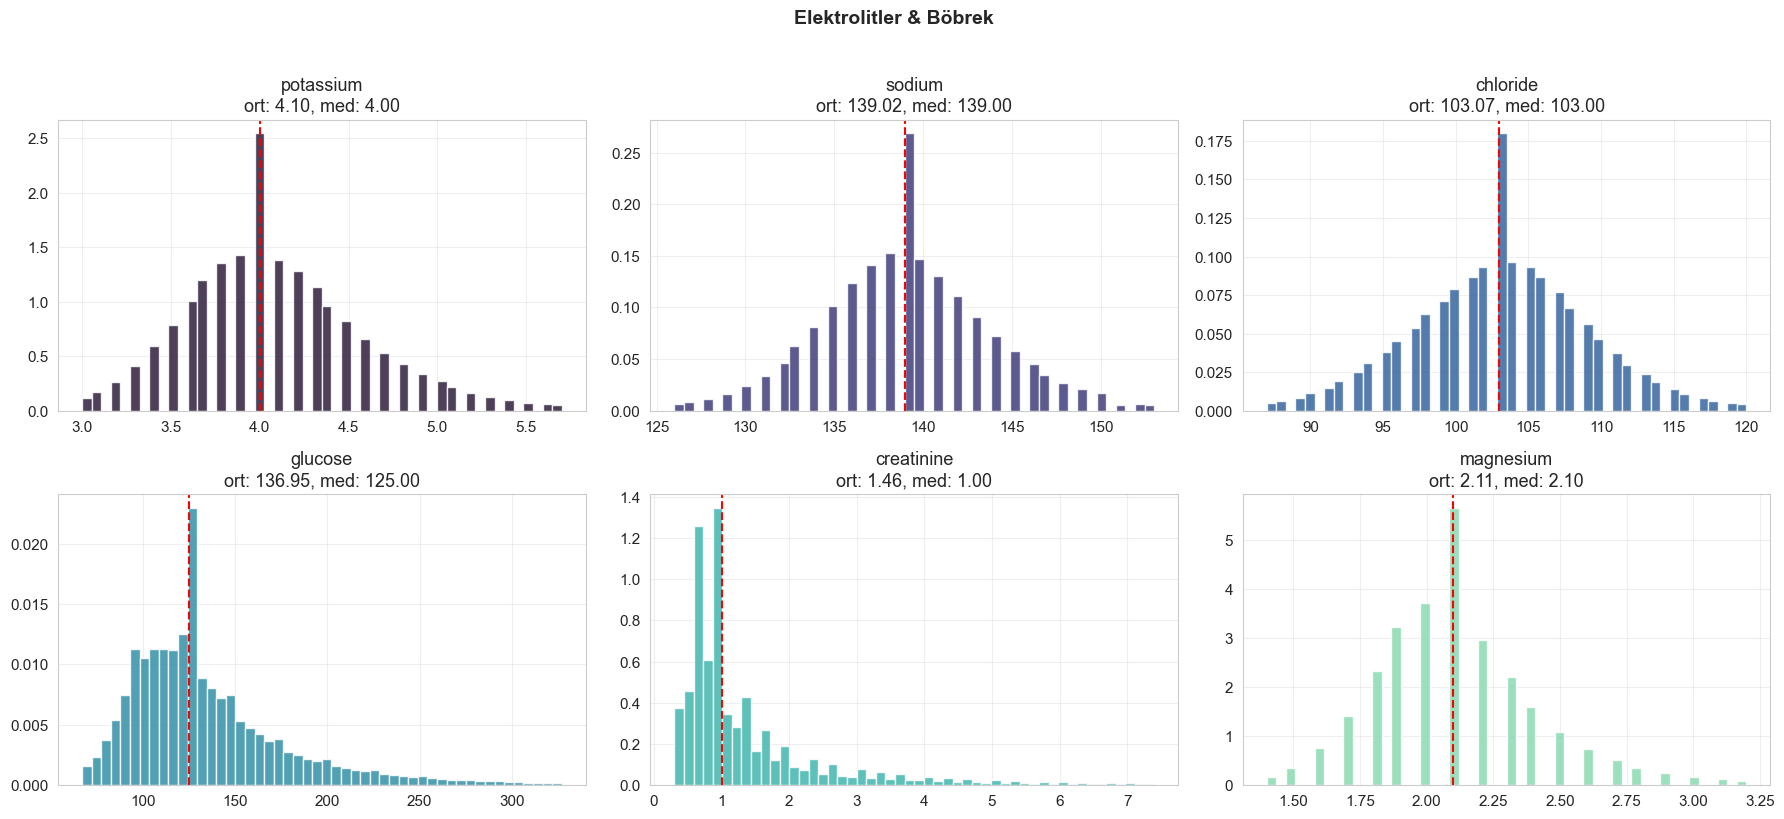

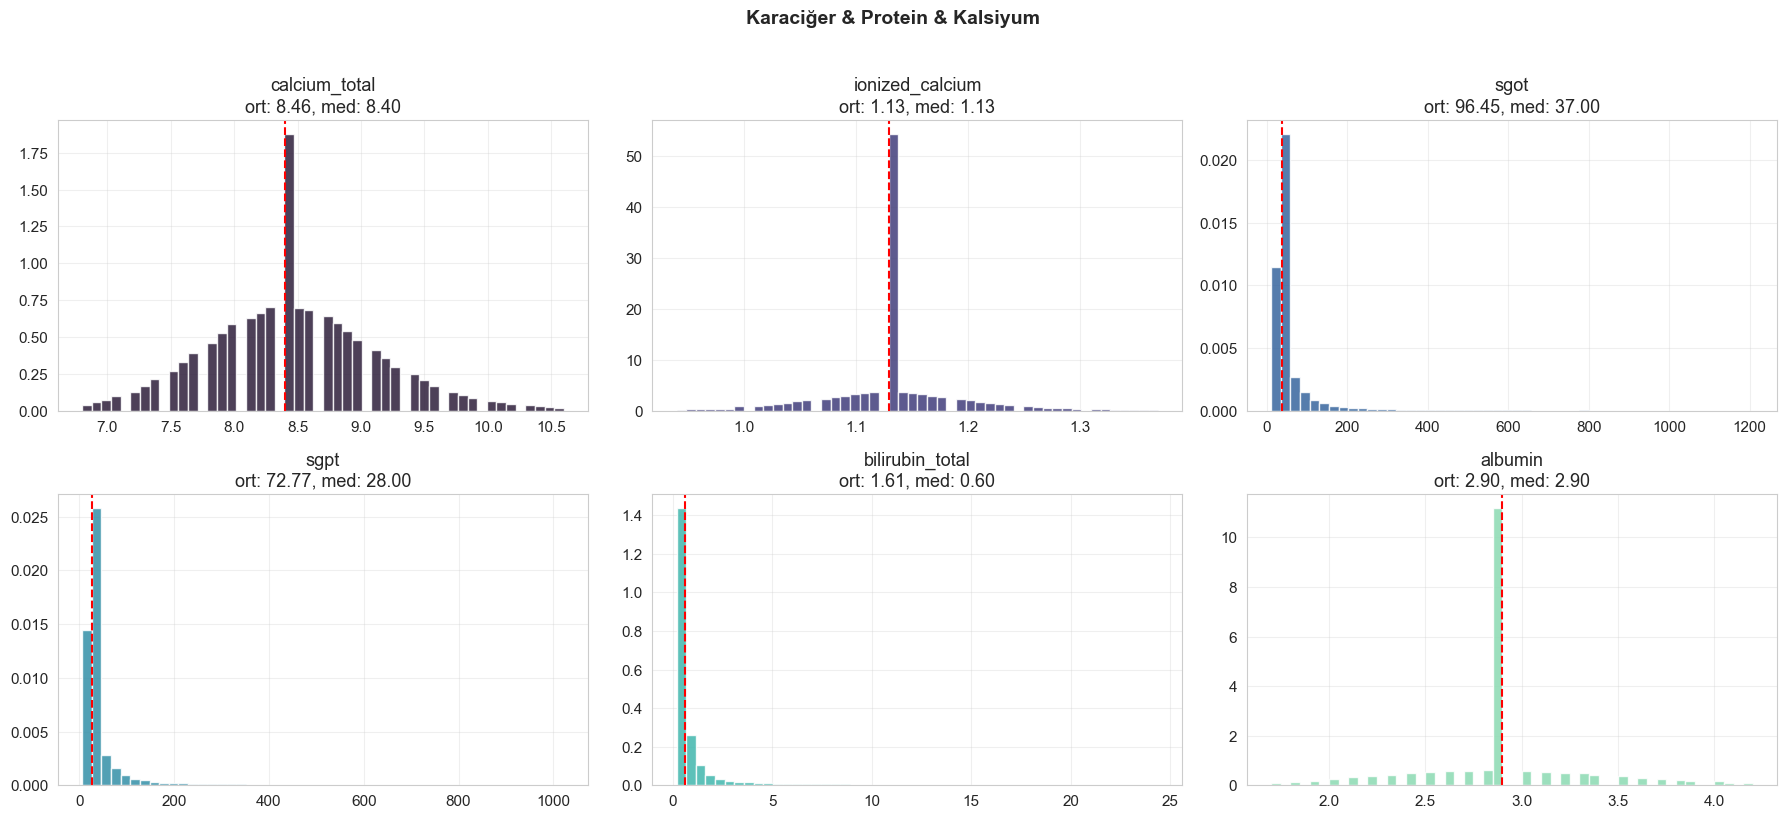

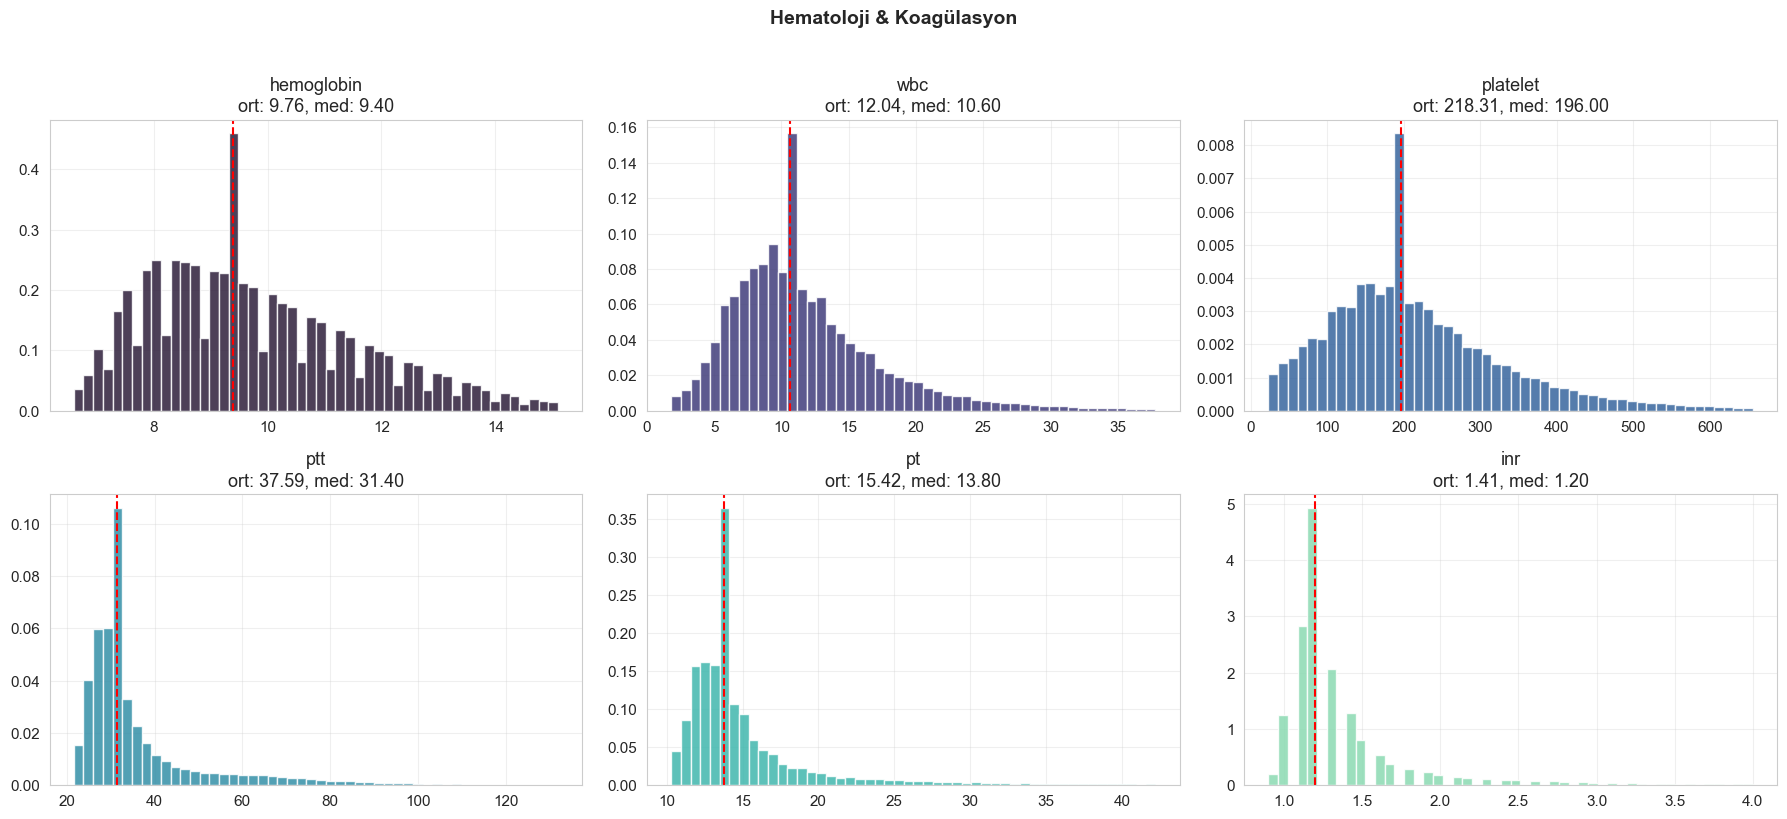

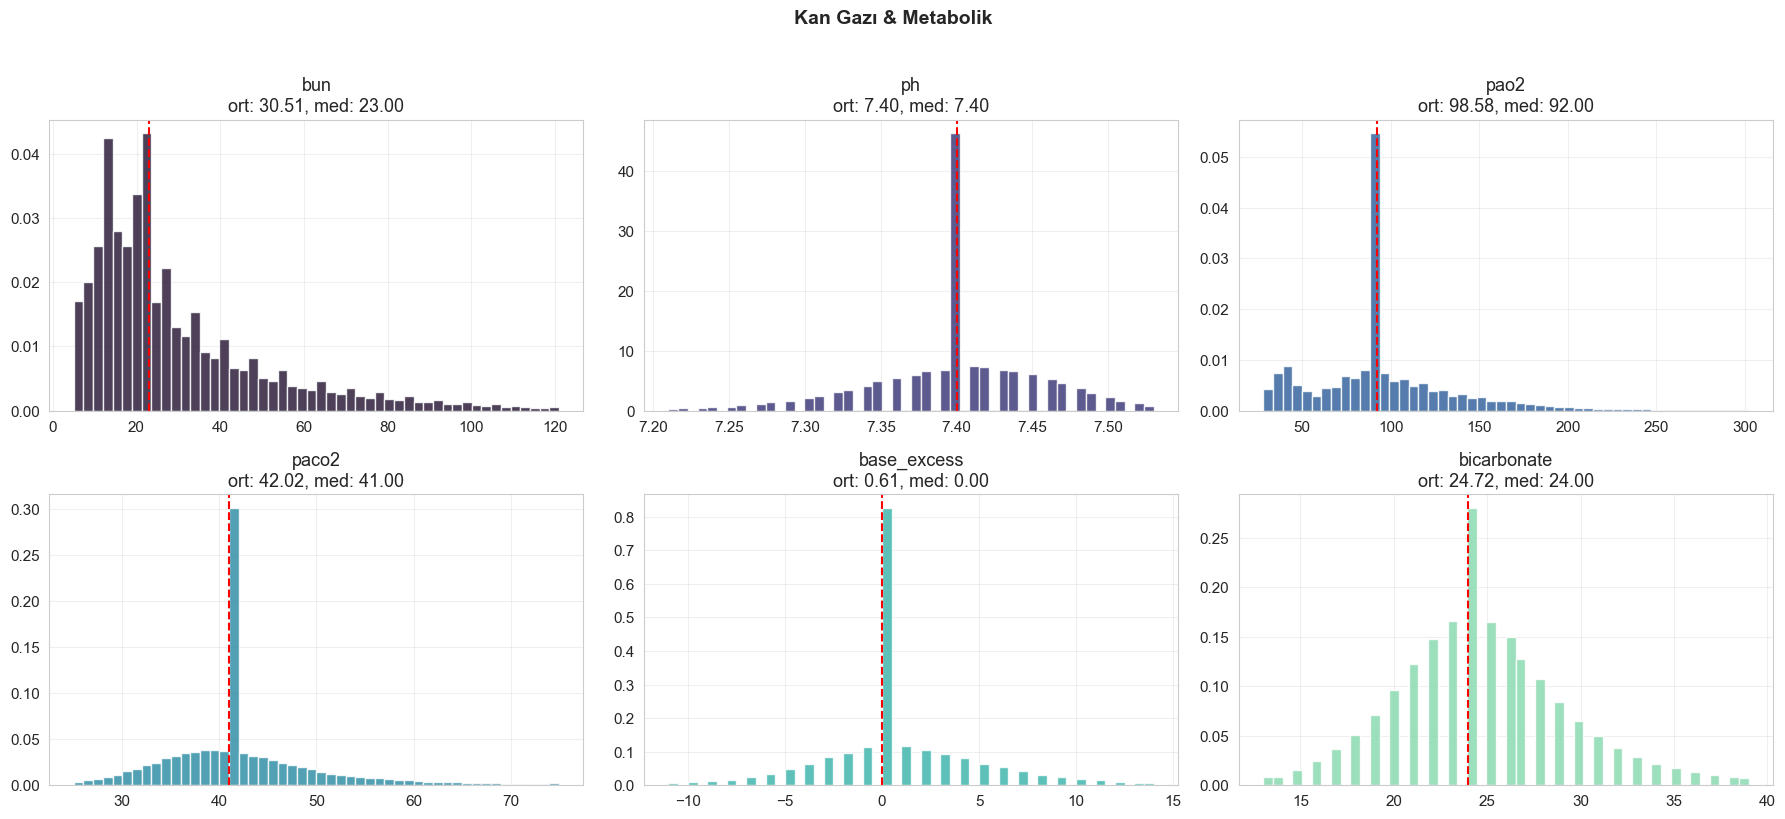

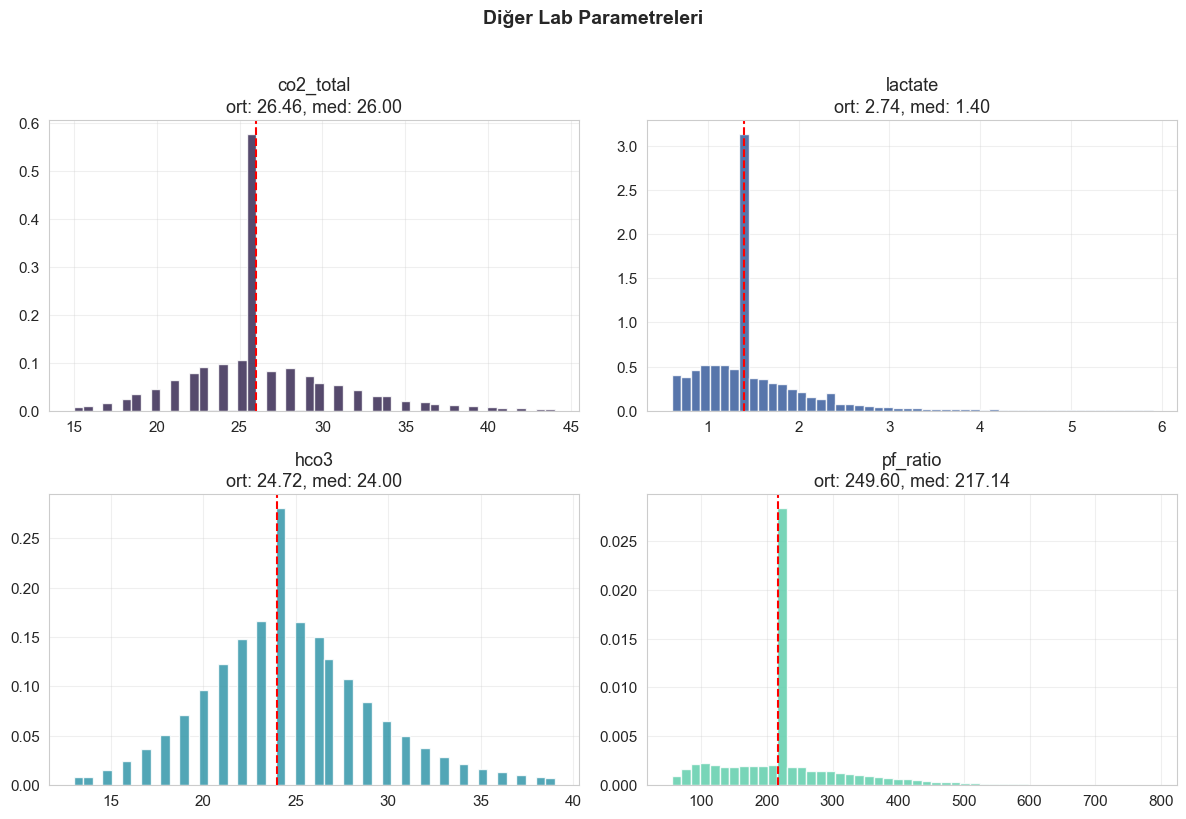

In [8]:
labs_group1 = ['potassium', 'sodium', 'chloride', 'glucose', 'creatinine', 'magnesium']
labs_group2 = ['calcium_total', 'ionized_calcium', 'sgot', 'sgpt', 'bilirubin_total', 'albumin']
labs_group3 = ['hemoglobin', 'wbc', 'platelet', 'ptt', 'pt', 'inr']
labs_group4 = ['bun', 'ph', 'pao2', 'paco2', 'base_excess', 'bicarbonate']
labs_group5 = ['co2_total', 'lactate', 'hco3', 'pf_ratio']

def plot_lab_group(lab_list, title, ncols=3):
    nrows = (len(lab_list) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
    if nrows == 1 and ncols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, lab in enumerate(lab_list):
        data = df[lab].drop_nulls().to_numpy()
        # Outlier'ları kırp (görselleştirme için)
        q01, q99 = np.percentile(data, [1, 99])
        data_clipped = data[(data >= q01) & (data <= q99)]
        
        axes[i].hist(data_clipped, bins=50, color=sns.color_palette('mako', len(lab_list))[i], 
                     edgecolor='white', alpha=0.85, density=True)
        axes[i].set_title(f'{lab}\nort: {np.mean(data):.2f}, med: {np.median(data):.2f}')
        axes[i].axvline(np.median(data), color='red', linestyle='--', linewidth=1.5)
    
    for j in range(len(lab_list), len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

plot_lab_group(labs_group1, 'Elektrolitler & Böbrek')
plot_lab_group(labs_group2, 'Karaciğer & Protein & Kalsiyum')
plot_lab_group(labs_group3, 'Hematoloji & Koagülasyon')
plot_lab_group(labs_group4, 'Kan Gazı & Metabolik')
plot_lab_group(labs_group5, 'Diğer Lab Parametreleri', ncols=2)

## 7. Klinik Skorlar (SOFA & SIRS)

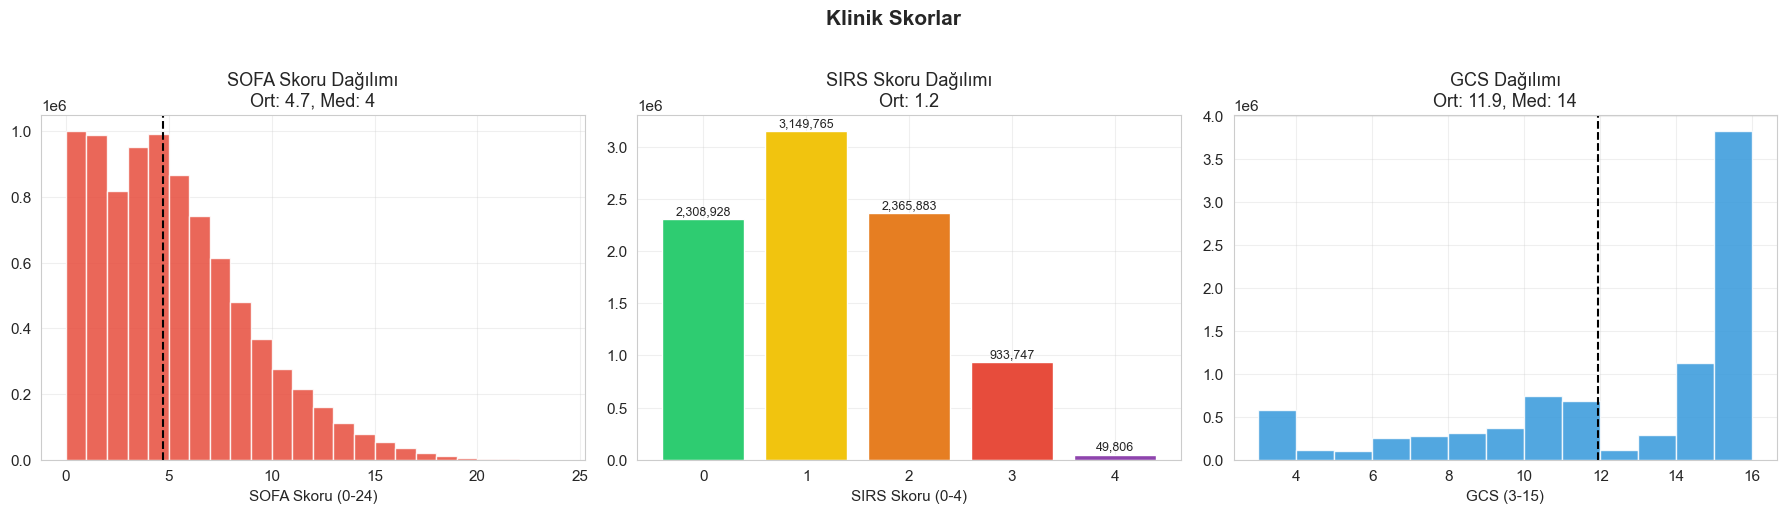


📊 SOFA Ağırlık Kategorileri:
  0-5  (Düşük):  5,620,051 (63.8%)
  6-10 (Orta):   2,485,087 (28.2%)
  11-15 (Yüksek): 622,105 (7.1%)
  >15 (Kritik):   80,886 (0.9%)


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# SOFA Skoru
sofa_data = df['sofa_score'].drop_nulls().to_numpy()
axes[0].hist(sofa_data, bins=range(0, 25), color='#e74c3c', edgecolor='white', alpha=0.85)
axes[0].set_title(f'SOFA Skoru Dağılımı\nOrt: {np.mean(sofa_data):.1f}, Med: {np.median(sofa_data):.0f}')
axes[0].set_xlabel('SOFA Skoru (0-24)')
axes[0].axvline(np.mean(sofa_data), color='black', linestyle='--', linewidth=1.5)

# SIRS Skoru
sirs_data = df['sirs_score'].drop_nulls().to_numpy()
sirs_counts = np.bincount(sirs_data.astype(int), minlength=5)
axes[1].bar(range(5), sirs_counts, color=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c', '#8e44ad'], 
            edgecolor='white')
axes[1].set_title(f'SIRS Skoru Dağılımı\nOrt: {np.mean(sirs_data):.1f}')
axes[1].set_xlabel('SIRS Skoru (0-4)')
axes[1].set_xticks(range(5))
for i, v in enumerate(sirs_counts):
    axes[1].text(i, v + df.shape[0]*0.005, f'{v:,}', ha='center', fontsize=9)

# GCS
gcs_data = df['gcs_total'].drop_nulls().to_numpy()
axes[2].hist(gcs_data, bins=range(3, 17), color='#3498db', edgecolor='white', alpha=0.85)
axes[2].set_title(f'GCS Dağılımı\nOrt: {np.mean(gcs_data):.1f}, Med: {np.median(gcs_data):.0f}')
axes[2].set_xlabel('GCS (3-15)')
axes[2].axvline(np.mean(gcs_data), color='black', linestyle='--', linewidth=1.5)

plt.suptitle('Klinik Skorlar', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# SOFA kategorileri
print('\n📊 SOFA Ağırlık Kategorileri:')
print(f'  0-5  (Düşük):  {np.sum(sofa_data <= 5):,} ({np.sum(sofa_data <= 5)/len(sofa_data)*100:.1f}%)')
print(f'  6-10 (Orta):   {np.sum((sofa_data > 5) & (sofa_data <= 10)):,} ({np.sum((sofa_data > 5) & (sofa_data <= 10))/len(sofa_data)*100:.1f}%)')
print(f'  11-15 (Yüksek): {np.sum((sofa_data > 10) & (sofa_data <= 15)):,} ({np.sum((sofa_data > 10) & (sofa_data <= 15))/len(sofa_data)*100:.1f}%)')
print(f'  >15 (Kritik):   {np.sum(sofa_data > 15):,} ({np.sum(sofa_data > 15)/len(sofa_data)*100:.1f}%)')

## 8. Solunum & Sıvı Parametreleri

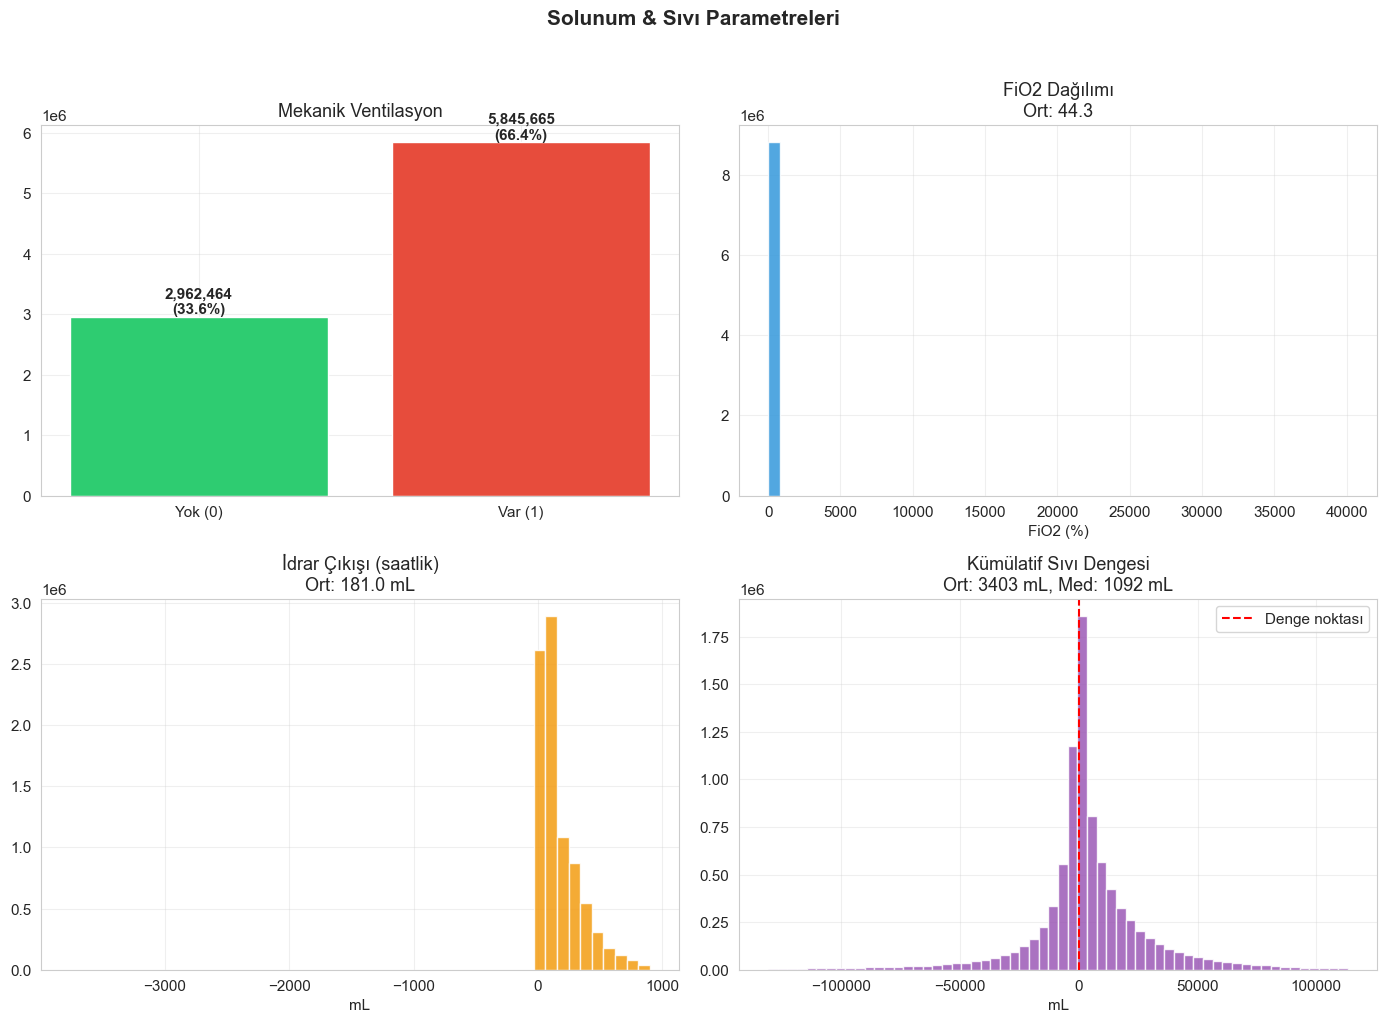

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mechanical Ventilation
mv_counts = df['mechanical_ventilation'].value_counts().sort('mechanical_ventilation')
axes[0, 0].bar(['Yok (0)', 'Var (1)'], mv_counts['count'].to_list(), 
               color=['#2ecc71', '#e74c3c'], edgecolor='white')
axes[0, 0].set_title('Mekanik Ventilasyon')
for i, v in enumerate(mv_counts['count'].to_list()):
    axes[0, 0].text(i, v + df.shape[0]*0.005, f'{v:,}\n({v/df.shape[0]*100:.1f}%)', ha='center', fontweight='bold')

# FiO2
fio2_data = df['fio2'].drop_nulls().to_numpy()
axes[0, 1].hist(fio2_data, bins=50, color='#3498db', edgecolor='white', alpha=0.85)
axes[0, 1].set_title(f'FiO2 Dağılımı\nOrt: {np.mean(fio2_data):.1f}')
axes[0, 1].set_xlabel('FiO2 (%)')

# Urine Output
urine_data = df['urine_output'].drop_nulls().to_numpy()
urine_clipped = urine_data[urine_data <= np.percentile(urine_data, 99)]
axes[1, 0].hist(urine_clipped, bins=50, color='#f39c12', edgecolor='white', alpha=0.85)
axes[1, 0].set_title(f'İdrar Çıkışı (saatlik)\nOrt: {np.mean(urine_data):.1f} mL')
axes[1, 0].set_xlabel('mL')

# Cumulative Fluid Balance
cfb_data = df['cumulative_fluid_balance'].drop_nulls().to_numpy()
q01, q99 = np.percentile(cfb_data, [1, 99])
cfb_clipped = cfb_data[(cfb_data >= q01) & (cfb_data <= q99)]
axes[1, 1].hist(cfb_clipped, bins=60, color='#9b59b6', edgecolor='white', alpha=0.85)
axes[1, 1].set_title(f'Kümülatif Sıvı Dengesi\nOrt: {np.mean(cfb_data):.0f} mL, Med: {np.median(cfb_data):.0f} mL')
axes[1, 1].set_xlabel('mL')
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=1.5, label='Denge noktası')
axes[1, 1].legend()

plt.suptitle('Solunum & Sıvı Parametreleri', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 9. Korelasyon Matrisi (Feature İlişkileri)

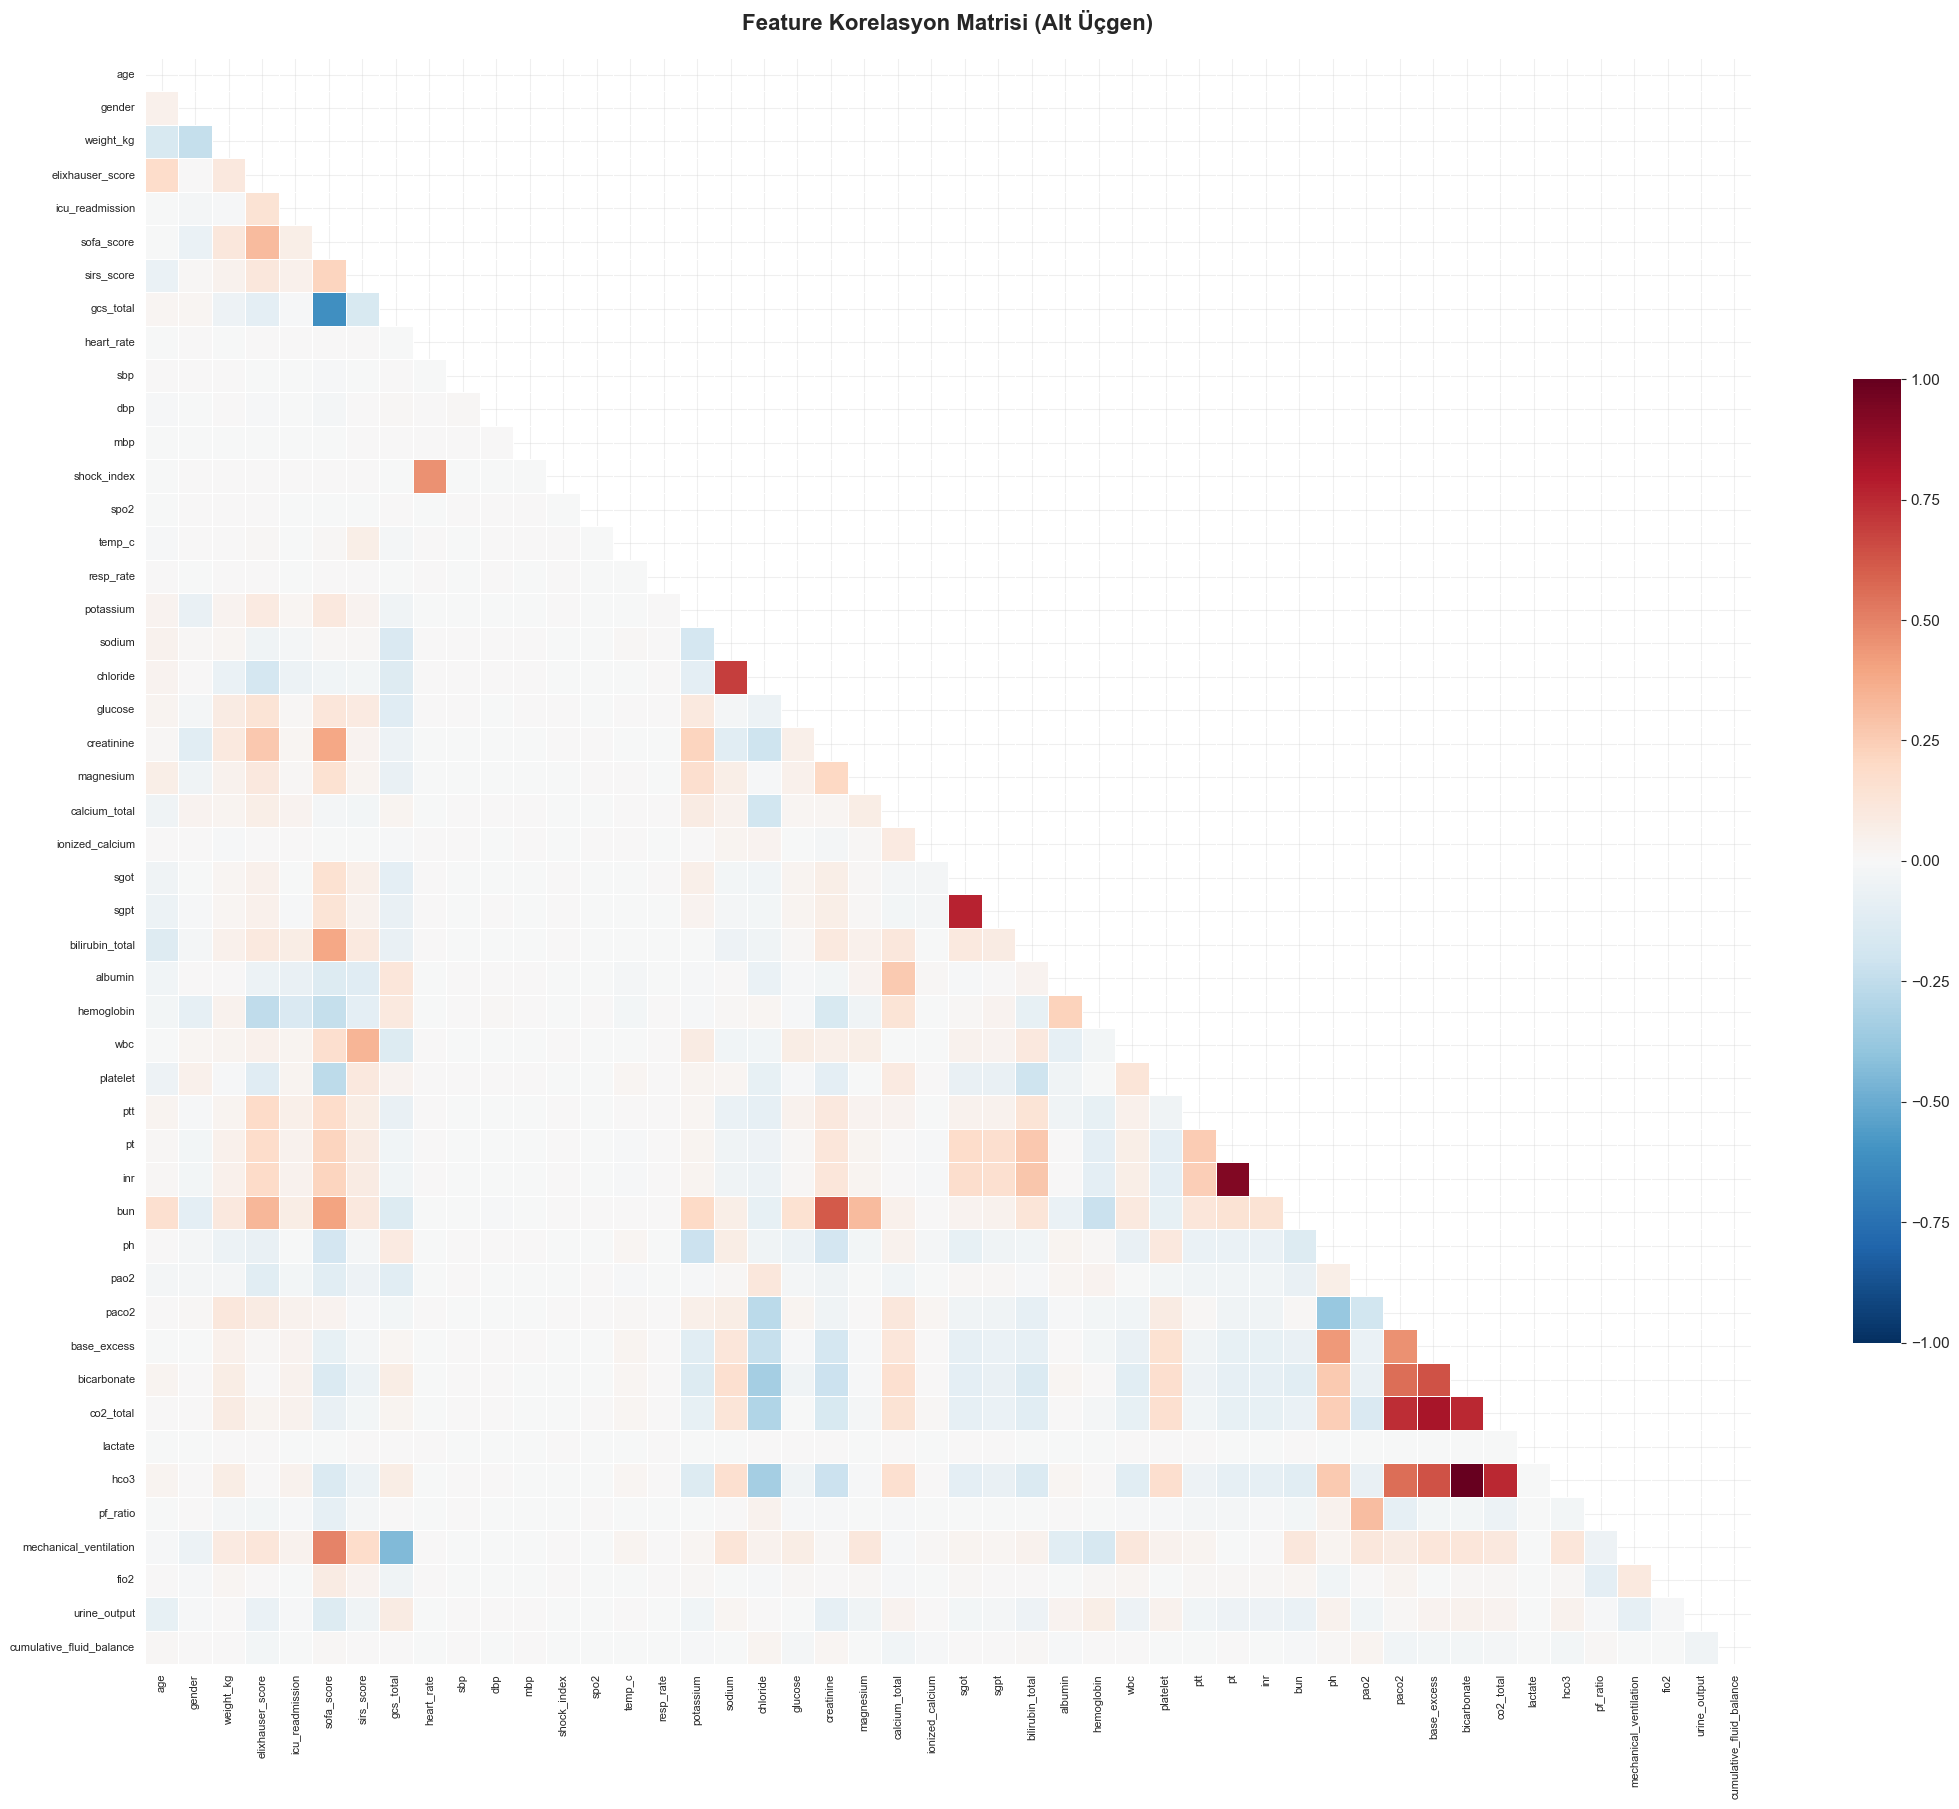


🔗 Yüksek Korelasyonlar (|r| > 0.7):
  🔴 bicarbonate               ↔ hco3                       r = +1.000
  🔴 pt                        ↔ inr                        r = +0.924
  🔴 base_excess               ↔ co2_total                  r = +0.821
  🔴 sgot                      ↔ sgpt                       r = +0.770
  🔴 co2_total                 ↔ hco3                       r = +0.750
  🔴 bicarbonate               ↔ co2_total                  r = +0.750
  🔴 paco2                     ↔ co2_total                  r = +0.740


In [11]:
# Pandas'a çevir (seaborn heatmap için)
numeric_features = [c for c in feature_cols if df[c].dtype in (pl.Float64, pl.Float32, pl.Int32, pl.Int64)]
corr_df = df.select(numeric_features).to_pandas()
corr_matrix = corr_df.corr()

fig, ax = plt.subplots(figsize=(22, 18))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.6},
            annot=False, fmt='.2f', ax=ax,
            vmin=-1, vmax=1)
ax.set_title('Feature Korelasyon Matrisi (Alt Üçgen)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# En yüksek korelasyonlar (|r| > 0.7)
print('\n🔗 Yüksek Korelasyonlar (|r| > 0.7):')
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        r = corr_matrix.iloc[i, j]
        if abs(r) > 0.7:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], r))
high_corr.sort(key=lambda x: abs(x[2]), reverse=True)
for f1, f2, r in high_corr:
    emoji = '🔴' if r > 0 else '🔵'
    print(f'  {emoji} {f1:25s} ↔ {f2:25s}  r = {r:+.3f}')

## 10. Örnek Hasta Trajektorisi

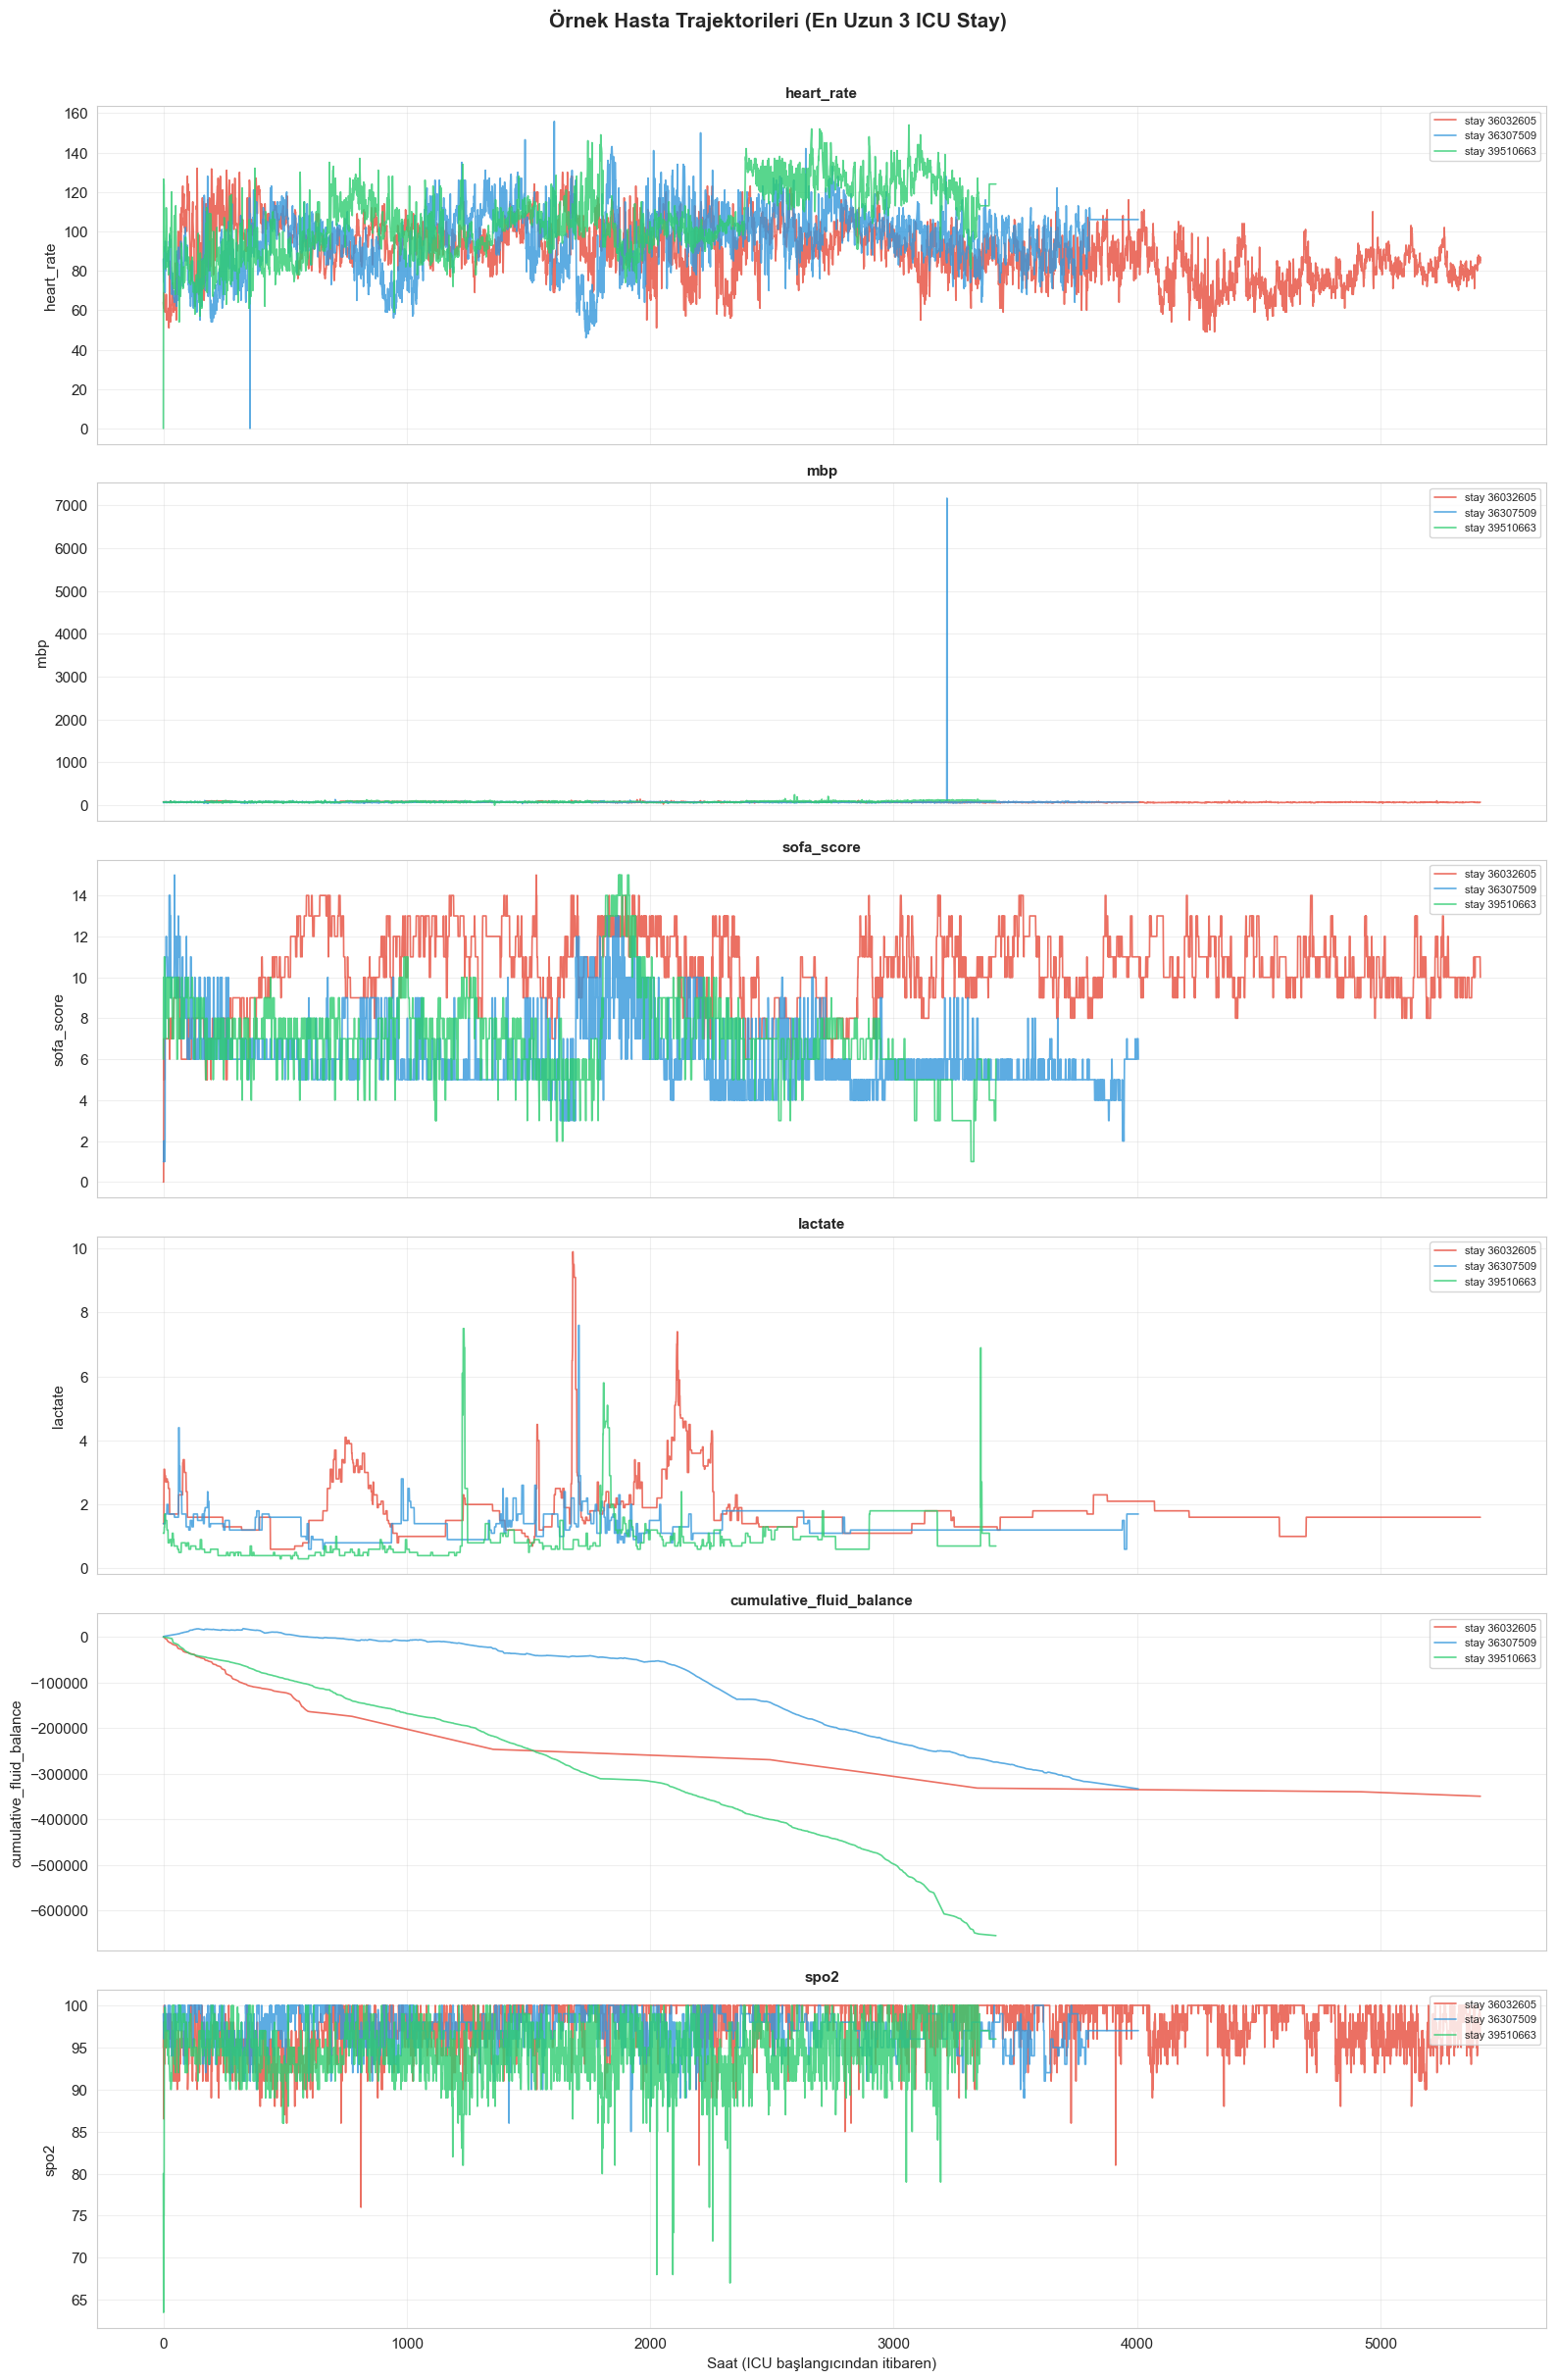

In [12]:
# En uzun ICU stay'i olan 3 hastayı seç
top_stays = (
    df.group_by('stay_id').len()
    .sort('len', descending=True)
    .head(3)['stay_id'].to_list()
)

track_features = ['heart_rate', 'mbp', 'sofa_score', 'lactate', 'cumulative_fluid_balance', 'spo2']

fig, axes = plt.subplots(len(track_features), 1, figsize=(16, 4*len(track_features)), sharex=True)

colors_patients = ['#e74c3c', '#3498db', '#2ecc71']

for ax, feat in zip(axes, track_features):
    for stay_id, color in zip(top_stays, colors_patients):
        patient = df.filter(pl.col('stay_id') == stay_id).sort('hour_bin')
        hours = np.arange(len(patient))
        values = patient[feat].to_numpy()
        ax.plot(hours, values, color=color, alpha=0.8, linewidth=1.2, label=f'stay {stay_id}')
    ax.set_ylabel(feat)
    ax.set_title(feat, fontsize=11, fontweight='bold')
    ax.legend(fontsize=8, loc='upper right')

axes[-1].set_xlabel('Saat (ICU başlangıcından itibaren)')
plt.suptitle('Örnek Hasta Trajektorileri (En Uzun 3 ICU Stay)', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## 📋 Özet Tablo

In [13]:
# Feature kategorileri
categories = {
    'Demografi': ['age', 'gender', 'weight_kg', 'elixhauser_score', 'icu_readmission'],
    'Skorlar': ['sofa_score', 'sirs_score', 'gcs_total'],
    'Vitals': ['heart_rate', 'sbp', 'dbp', 'mbp', 'shock_index', 'spo2', 'temp_c', 'resp_rate'],
    'Elektrolitler': ['potassium', 'sodium', 'chloride', 'glucose', 'magnesium', 'calcium_total', 'ionized_calcium'],
    'Böbrek & Karaciğer': ['creatinine', 'bun', 'sgot', 'sgpt', 'bilirubin_total', 'albumin'],
    'Hematoloji': ['hemoglobin', 'wbc', 'platelet', 'ptt', 'pt', 'inr'],
    'Kan Gazı': ['ph', 'pao2', 'paco2', 'base_excess', 'bicarbonate', 'co2_total', 'lactate', 'hco3', 'pf_ratio'],
    'Solunum & Sıvı': ['mechanical_ventilation', 'fio2', 'urine_output', 'cumulative_fluid_balance'],
}

print('=' * 80)
print(f'{"KATEGORİ":20s} {"FEATURE":25s} {"ORT":>10s} {"MED":>10s} {"MIN":>10s} {"MAX":>10s} {"NULL%":>8s}')
print('=' * 80)

for cat, features in categories.items():
    print(f'\n── {cat} ({len(features)} feature) ──')
    for feat in features:
        if feat in df.columns:
            col = df[feat]
            null_pct = col.null_count() / df.shape[0] * 100
            if col.dtype in (pl.Float64, pl.Float32, pl.Int32, pl.Int64):
                print(f'  {feat:25s} {col.mean():>10.2f} {col.median():>10.2f} {col.min():>10.2f} {col.max():>10.2f} {null_pct:>7.1f}%')
            else:
                print(f'  {feat:25s} {"—":>10s} {"—":>10s} {"—":>10s} {"—":>10s} {null_pct:>7.1f}%')

print('\n' + '=' * 80)
print(f'\n✅ Toplam: {len(feature_cols)} feature, {df.shape[0]:,} satır, {df["stay_id"].n_unique():,} hasta')
print(f'📦 Dosya boyutu: ~{STATE_PARQUET_PATH.stat().st_size / 1e6:.0f} MB' if False else '')
print('🎯 State vektörü DRL agent için hazır!')

KATEGORİ             FEATURE                          ORT        MED        MIN        MAX    NULL%

── Demografi (5 feature) ──
  age                            62.64      64.00      18.00      91.00     0.0%
  gender                          0.42       0.00       0.00       1.00     0.0%
  weight_kg                      84.02      80.20       0.00    1007.88     0.0%
  elixhauser_score                5.39       5.00       0.00      16.00     0.0%
  icu_readmission                 0.13       0.00       0.00       1.00     0.0%

── Skorlar (3 feature) ──
  sofa_score                      4.72       4.00       0.00      23.00     0.0%
  sirs_score                      1.24       1.00       0.00       4.00     0.0%
  gcs_total                      11.95      14.00       1.00      15.00     0.0%

── Vitals (8 feature) ──
  heart_rate                     87.81      85.00 -241395.00 10000000.00     0.0%
  sbp                           120.46     118.00     -94.00 1003110.00     0.0%
  dbp  